In [27]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
from tqdm import tqdm
from itertools import product
from Bio import SeqIO
from sklearn.preprocessing import StandardScaler
from collections import Counter

In [2]:
PATH_FEATURES = '/home/parazit/ml_virus_host/v2.0/Features/'

In [3]:
meta_df = pd.read_csv('/home/parazit/ml_virus_host/v2.0/data/data_table.tsv', sep='\t', index_col='refseq id')

In [8]:
gbid2taxid = meta_df['virus tax id'].to_dict()
full_seq_names = list(gbid2taxid.keys())

seq_index = {}
for i, seq_name in enumerate(full_seq_names):
    seq_index[seq_name] = i

In [113]:
features = ['AA']
dna_alph = 'acgt'
aa_alph = 'ARNDCEQGHILKMFPSTWYV'
kmer_lists = [[1, 2, 3, 4], # orf
             ]  
feature_sets = [f'{f}_{k}' for i,f in enumerate(features) for k in kmer_lists[i] ]

In [114]:
feature_sets

['AA_1', 'AA_2', 'AA_3', 'AA_4']

In [86]:
def check_nonamb(seq, alphabet):
    return all(s in alphabet for s in seq)


'''
feature name - str - code for feature (e.g. DNA_1, AA_9)
sequences - list with Seq objects
seq_index - dict - dictionary, seq_index[gb_id] = the number of sequences that correspond to one full genome
'''
def get_kmer_features(feature_name, sequences, seq_index, shift=None):
    type_feature = feature_name.split('_')[0]
    k = int(feature_name.split('_')[1])
    if type_feature == 'DNA' or type_feature == 'ORF':
        alphabet = dna_alph
    if type_feature == 'AA':
        alphabet = aa_alph
    all_kmers =[''.join(c) for c in product(alphabet, repeat=k)]
    
    # names of sequences with ambiguous nts
    #names_amb = []
    
    X = np.zeros((len(seq_index) ,len(all_kmers)))
    #row_names = list(sequences.keys())
    col_names = all_kmers
    
    #  the number of sequences that correspond to one full genome, needed for cds
    gbid_count = np.zeros(len(seq_index))
    
    #feature_dict_temp = {k:0 for k in all_kmers}
    #feature_dict = {seq_name:feature_dict_temp for seq_name in full_seq_names}

    
    for j, record in tqdm(enumerate(sequences)):
        #print(seq_name)
        feature_dict = {a:0 for a in all_kmers}
        
        if shift != None:
            for i in range(0 + shift, len(record.seq)-k+1, k):
                w =  record.seq[i:i+k]
                if check_nonamb(w, alphabet):
                    feature_dict[w] += 1

        else:
            for i in range(len(record.seq)-k+1):
                w =  record.seq[i:i+k]
                if check_nonamb(w, alphabet):
                    feature_dict[w] += 1
                #else:
                #    names_amb.append(seq_name)
        if type_feature == 'DNA':
            ind = seq_index[record.name]
        if type_feature == 'AA' or type_feature == 'ORF':
            ind = seq_index[record.description]
        X[ind] = np.array(list(feature_dict.values()))/len(record.seq)
        gbid_count[ind] +=1
    #names_amb = set(names_amb)
    return X, col_names, gbid_count#, names_amb

In [105]:
#seq_rna = list(SeqIO.parse('/home/parazit/ml_virus_host/v2.0/data.fasta', 'fasta'))
#for rec in seq_rna:
    #rec.name = rec.description.split('|')[0]
    #rec.description = rec.description.split('|')[-2]
seq_cds = list(SeqIO.parse('/home/parazit/ml_virus_host/v2.0/data/cds_data.fasta', 'fasta'))

In [106]:
feature_sets

['AA_1', 'AA_2', 'AA_3']

In [143]:
for feature in tqdm(feature_sets):
    type_feature = feature.split('_')[0]
    
    if type_feature == 'ORF':
        for shift in range(3):
            X_raw, col_names, gbid_count = get_kmer_features(feature, seq_orf, seq_index, shift)
            X = X_raw / gbid_count[:, np.newaxis]
            df = pd.DataFrame(data=X, index=full_seq_names, columns=col_names)
            df.to_csv(PATH_FEATURES + feature + str(shift) + '.csv')
    else:
        if type_feature == 'DNA':
            X, col_names, gbid_count = get_kmer_features(feature, seq_rna, seq_index)
        if type_feature == 'AA':
            X_raw, col_names, gbid_count = get_kmer_features(feature, seq_cds, seq_index)
            X = X_raw / gbid_count[:, np.newaxis]

        df = pd.DataFrame(data=X, index=full_seq_names, columns=col_names)
        df.to_csv(PATH_FEATURES + feature + '.csv')

  0%|                                                     | 0/4 [00:00<?, ?it/s]
0it [00:00, ?it/s]
34it [00:00, 335.81it/s]
75it [00:00, 377.61it/s]
115it [00:00, 370.93it/s]
160it [00:00, 400.01it/s]
217it [00:00, 459.63it/s]
264it [00:00, 451.82it/s]
310it [00:00, 449.59it/s]
357it [00:00, 441.49it/s]
408it [00:00, 459.49it/s]
467it [00:01, 494.56it/s]
517it [00:01, 479.36it/s]
566it [00:01, 476.60it/s]
614it [00:01, 477.26it/s]
662it [00:01, 463.65it/s]
709it [00:01, 408.04it/s]
751it [00:01, 348.24it/s]
788it [00:01, 325.40it/s]
829it [00:02, 342.88it/s]
865it [00:02, 321.07it/s]
902it [00:02, 330.67it/s]
936it [00:02, 299.36it/s]
970it [00:02, 308.24it/s]
1002it [00:02, 278.54it/s]
1031it [00:02, 267.47it/s]
1068it [00:02, 290.74it/s]
1116it [00:02, 338.26it/s]
1151it [00:03, 330.60it/s]
1220it [00:03, 428.96it/s]
1265it [00:03, 382.69it/s]
1313it [00:03, 398.85it/s]
1371it [00:03, 446.99it/s]
1418it [00:03, 386.45it/s]
1463it [00:03, 402.13it/s]
1509it [00:03, 417.02it/s]
1561it

2063it [00:07, 282.74it/s]
2092it [00:07, 282.28it/s]
2121it [00:07, 282.26it/s]
2150it [00:07, 266.15it/s]
2177it [00:07, 266.41it/s]
2206it [00:08, 271.98it/s]
2234it [00:08, 264.08it/s]
2274it [00:08, 298.77it/s]
2315it [00:08, 330.16it/s]
2361it [00:08, 367.22it/s]
2403it [00:08, 381.02it/s]
2447it [00:08, 397.56it/s]
2496it [00:08, 423.73it/s]
2539it [00:08, 382.91it/s]
2579it [00:09, 337.62it/s]
2630it [00:09, 380.96it/s]
2670it [00:09, 345.34it/s]
2707it [00:09, 309.45it/s]
2740it [00:09, 309.25it/s]
2773it [00:09, 311.77it/s]
2814it [00:09, 336.53it/s]
2851it [00:09, 344.98it/s]
2887it [00:09, 310.10it/s]
2935it [00:10, 354.05it/s]
2989it [00:10, 402.09it/s]
3036it [00:10, 417.17it/s]
3079it [00:10, 383.96it/s]
3119it [00:10, 364.59it/s]
3164it [00:10, 386.41it/s]
3204it [00:10, 331.99it/s]
3240it [00:10, 329.29it/s]
3285it [00:11, 359.57it/s]
3323it [00:11, 353.63it/s]
3360it [00:11, 345.00it/s]
3396it [00:11, 337.36it/s]
3431it [00:11, 293.83it/s]
3479it [00:11, 339.37it/s]
3

1039it [00:23, 42.87it/s]
1044it [00:23, 43.29it/s]
1049it [00:24, 41.28it/s]
1055it [00:24, 44.10it/s]
1060it [00:24, 42.55it/s]
1066it [00:24, 45.03it/s]
1071it [00:24, 42.93it/s]
1076it [00:24, 44.71it/s]
1081it [00:24, 42.85it/s]
1086it [00:24, 44.54it/s]
1091it [00:24, 42.91it/s]
1097it [00:25, 45.34it/s]
1102it [00:25, 44.58it/s]
1107it [00:25, 44.12it/s]
1112it [00:25, 45.09it/s]
1117it [00:25, 45.30it/s]
1122it [00:25, 46.57it/s]
1127it [00:25, 42.26it/s]
1132it [00:25, 44.17it/s]
1137it [00:25, 44.34it/s]
1142it [00:26, 42.85it/s]
1147it [00:26, 41.65it/s]
1152it [00:26, 43.28it/s]
1157it [00:26, 44.05it/s]
1162it [00:26, 45.35it/s]
1167it [00:26, 45.71it/s]
1172it [00:26, 45.75it/s]
1177it [00:26, 46.82it/s]
1182it [00:26, 46.71it/s]
1187it [00:27, 46.83it/s]
1192it [00:27, 47.39it/s]
1197it [00:27, 46.97it/s]
1202it [00:27, 47.63it/s]
1207it [00:27, 47.39it/s]
1212it [00:27, 47.01it/s]
1217it [00:27, 47.35it/s]
1222it [00:27, 47.06it/s]
1227it [00:27, 46.95it/s]
1232it [00:2

2450it [00:55, 46.58it/s]
2455it [00:55, 47.01it/s]
2460it [00:56, 46.21it/s]
2466it [00:56, 47.48it/s]
2471it [00:56, 47.11it/s]
2476it [00:56, 47.40it/s]
2481it [00:56, 47.25it/s]
2486it [00:56, 46.31it/s]
2491it [00:56, 47.03it/s]
2496it [00:56, 46.75it/s]
2501it [00:56, 47.37it/s]
2506it [00:57, 47.38it/s]
2511it [00:57, 47.23it/s]
2516it [00:57, 47.03it/s]
2521it [00:57, 46.69it/s]
2526it [00:57, 45.63it/s]
2531it [00:57, 42.35it/s]
2536it [00:57, 44.10it/s]
2541it [00:57, 44.30it/s]
2546it [00:57, 42.67it/s]
2551it [00:58, 42.10it/s]
2556it [00:58, 43.01it/s]
2561it [00:58, 42.38it/s]
2566it [00:58, 42.88it/s]
2571it [00:58, 43.68it/s]
2576it [00:58, 44.97it/s]
2581it [00:58, 45.55it/s]
2586it [00:58, 45.23it/s]
2592it [00:58, 46.89it/s]
2597it [00:59, 46.72it/s]
2602it [00:59, 45.97it/s]
2607it [00:59, 46.89it/s]
2612it [00:59, 46.13it/s]
2617it [00:59, 47.06it/s]
2622it [00:59, 47.69it/s]
2627it [00:59, 47.05it/s]
2632it [00:59, 46.82it/s]
2637it [00:59, 46.04it/s]
2642it [01:0

3867it [01:27, 46.20it/s]
3872it [01:27, 46.58it/s]
3877it [01:27, 46.42it/s]
3882it [01:27, 46.77it/s]
3887it [01:27, 46.32it/s]
3892it [01:27, 45.42it/s]
3897it [01:28, 46.66it/s]
3902it [01:28, 46.25it/s]
3907it [01:28, 45.23it/s]
3912it [01:28, 45.67it/s]
3917it [01:28, 44.68it/s]
3922it [01:28, 45.04it/s]
3927it [01:28, 44.17it/s]
3932it [01:28, 44.63it/s]
3937it [01:28, 45.74it/s]
3942it [01:29, 44.75it/s]
3947it [01:29, 45.33it/s]
3952it [01:29, 45.50it/s]
3957it [01:29, 44.10it/s]
3962it [01:29, 43.47it/s]
3967it [01:29, 43.67it/s]
3972it [01:29, 44.12it/s]
3977it [01:29, 45.22it/s]
3982it [01:29, 45.04it/s]
3987it [01:30, 43.99it/s]
3992it [01:30, 44.11it/s]
3997it [01:30, 44.85it/s]
4002it [01:30, 45.08it/s]
4007it [01:30, 45.20it/s]
4012it [01:30, 46.43it/s]
4017it [01:30, 46.77it/s]
4022it [01:30, 46.72it/s]
4027it [01:30, 44.49it/s]
4032it [01:31, 43.15it/s]
4037it [01:31, 42.98it/s]
4042it [01:31, 42.16it/s]
4047it [01:31, 42.61it/s]
4052it [01:31, 42.75it/s]
4057it [01:3

# CDS

In [4]:
total_df = pd.read_csv('/home/parazit/ml_virus_host/v2.0/data/virushostdb.tsv', sep='\t', index_col='virus tax id')

In [7]:
total_df.loc[meta_df['virus tax id']]

KeyError: '[95622, 627538, 348894, 121429, 136418, 566308] not in index'

In [5]:
meta_df = pd.read_csv('/home/parazit/ml_virus_host/v2.0/data/data_table.tsv', sep='\t', index_col='refseq id')
print(len(meta_df))
lost_ind = []

for lost_id in [95622, 627538, 348894, 121429, 136418, 566308]:
    lost_ind.append(meta_df[meta_df['virus tax id'] == lost_id].index[0])
    meta_df = meta_df.drop(meta_df[meta_df['virus tax id'] == lost_id].index)
print(len(meta_df))

1401
1395


In [13]:
lost_ind

['KT923141', 'NC_038368', 'NC_038862', 'NC_038863', 'NC_043411', 'NC_043416']

In [6]:
tmp1 = total_df.loc[meta_df['virus tax id']].drop_duplicates(subset=['refseq id'])

In [15]:
tmp1

,virus name,virus lineage,refseq id,KEGG GENOME,KEGG DISEASE,DISEASE,host tax id,host name,host lineage,pmid,evidence,sample type,source organism
virus tax id,,,,,,,,,,,,,
11138,Murine hepatitis virus,Viruses; Riboviria; Orthornavirae; Pisuviricot...,"NC_001846, NC_048217",NaN,NaN,NaN,10090.0,Mus musculus,Eukaryota; Opisthokonta; Metazoa; Eumetazoa; B...,NaN,UniProt,NaN,NaN
1587515,Black grass varicosavirus-like virus,Viruses; Riboviria; Orthornavirae; Negarnaviri...,"NC_026798, NC_026801",NaN,NaN,NaN,81473.0,Alopecurus myosuroides,Eukaryota; Viridiplantae; Streptophyta; Strept...,NaN,NaN,NaN,NaN
2010276,Culex phasma-like virus,Viruses; Riboviria; Orthornavirae; Negarnaviri...,"NC_055213, NC_055214, NC_055215",NaN,NaN,NaN,7176.0,Culex quinquefasciatus,Eukaryota; Opisthokonta; Metazoa; Eumetazoa; B...,28637756,Literature,NaN,NaN
12285,Black beetle virus,Viruses; Riboviria; Orthornavirae; Kitrinoviri...,"NC_001411, NC_002037",NaN,NaN,NaN,295550.0,Heteronychus arator,Eukaryota; Opisthokonta; Metazoa; Eumetazoa; B...,NaN,UniProt,NaN,NaN
1127767,Espirito Santo virus,Viruses; Riboviria; Orthornavirae; Birnavirida...,"NC_016517, NC_016518",NaN,NaN,NaN,7160.0,Aedes albopictus,Eukaryota; Opisthokonta; Metazoa; Eumetazoa; B...,22171264,Literature,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529909,Norovirus GI/Hu/JP/2007/GI.P3_GI.3/Shimizu/KK2866,Viruses; Riboviria; Orthornavirae; Pisuviricot...,NC_039897,NaN,NaN,NaN,9606.0,Homo sapiens,Eukaryota; Opisthokonta; Metazoa; Eumetazoa; B...,NaN,RefSeq,NaN,NaN
2161807,Marmot norovirus,Viruses; Riboviria; Orthornavirae; Pisuviricot...,NC_040674,NaN,NaN,NaN,93163.0,Marmota himalayana,Eukaryota; Opisthokonta; Metazoa; Eumetazoa; B...,NaN,"NCBI Virus, RefSeq",NaN,NaN
512169,Tulane virus,Viruses; Riboviria; Orthornavirae; Pisuviricot...,NC_043512,NaN,NaN,NaN,9534.0,Chlorocebus aethiops,Eukaryota; Opisthokonta; Metazoa; Eumetazoa; B...,18385231,Literature,NaN,NaN


In [73]:
with open ('/home/parazit/ml_virus_host/v2.0/data/virushostdb.cds.faa', 'r') as cds_fasta:
    fasta = list(SeqIO.parse(cds_fasta, 'fasta'))

In [74]:
with open ('/home/parazit/ml_virus_host/v2.0/data/virushostdb.cds.faa', 'r') as cds_fasta:
    fasta_ids=[]
    for seq in SeqIO.parse(cds_fasta, 'fasta'):
        fasta_ids.append(seq.description.split('|')[-2].split('.')[0])

In [75]:
lost_cds = []
for el in meta_df.index:
    if not el in fasta_ids:
        lost_cds.append(el)

In [76]:
def find_indices(list_to_check, item_to_find):
    return [idx for idx, value in enumerate(list_to_check) if value == item_to_find]

In [77]:
with open('cds_data.fasta', 'w') as output:
    no_seq=[]
    for el in list(tmp1['refseq id']):
        tmp, a = el.split(', '), []
        for seq_id in tmp:
            a.append(find_indices(fasta_ids, seq_id))
        full_seq = [item for sublist in a for item in sublist]
        seq_tmp = ''
        for index in full_seq:
            
            if full_seq.index(index) == 0:
                first = fasta[index]
                try:
                    help_description = first.description.split('|')[-2]
                except:
                    help_description = first.description
                    print(first.description)
            
            tmp_seq = fasta[index]
            tmp_seq.id, tmp_seq.description = help_description, help_description
            SeqIO.write(tmp_seq, output, 'fasta')
            '''
            seq_tmp += fasta[index].seq
            #print(full_seq[0], len(seq_tmp))
               
        if seq_tmp == '':
            no_seq.append(first.description)
        
        
        else:
            try:
                help_id = first.description.split('|')[-2]
            except:
                help_id = first.description
            first.seq, first.id, first.description = seq_tmp, help_id, help_id
            #first.seq = seq_tmp
            SeqIO.write(first, output, 'fasta')
            '''

NC_038759
NC_023420
NC_023420
NC_010415
NC_010415
NC_011553
AF241359
NC_004362
NC_004362
NC_018383
NC_003464
NC_004439
NC_004439
NC_003502
NC_017938
NC_005848
NC_031313
NC_031313


In [83]:
with open('cds_data.fasta', 'r') as inp:
    id_lst=[]
    for seq in SeqIO.parse(inp, 'fasta'):
        id_lst.append(seq.id)

In [102]:
no_data=[]
for i in id_lst:
    try:
        meta_df.loc[i]
    except:
        no_data.append(i)

In [103]:
no_data

['NC_015415',
 'NC_008038',
 'NC_008038',
 'NC_014599',
 'NC_005854',
 'NC_005854',
 'NC_010810',
 'AB236320',
 'AB236320',
 'AB236320',
 'NC_002565']

In [104]:
with open('cds_data_tmp.fasta', 'r') as inp, open('data/cds_data.fasta', 'w') as output:
    for seq in SeqIO.parse(inp, 'fasta'):
        if not seq.id in no_data:
            SeqIO.write(seq, output, 'fasta')

In [97]:
for el in no_cds:
    meta_df.drop(el)

KeyError: "['NC_015415'] not found in axis"

In [98]:
meta_df['NC_015415']

KeyError: 'NC_015415'

In [99]:
meta_df

,virus tax id,virus name,virus family,host,host name
refseq id,,,,,
NC_001846,11138,Murine hepatitis virus,Coronaviridae,Mammalia,Mus musculus
NC_026798,1587515,Black grass varicosavirus-like virus,Rhabdoviridae,Viridiplantae,Alopecurus myosuroides
NC_055213,2010276,Culex phasma-like virus,Phasmaviridae,Insecta,Culex quinquefasciatus
NC_001411,12285,Black beetle virus,Nodaviridae,Insecta,Heteronychus arator
NC_016517,1127767,Espirito Santo virus,Birnaviridae,Insecta,Aedes albopictus
...,...,...,...,...,...
NC_039897,1529909,Norovirus GI/Hu/JP/2007/GI.P3_GI.3/Shimizu/KK2866,Caliciviridae,Mammalia,Homo sapiens
NC_040674,2161807,Marmot norovirus,Caliciviridae,Mammalia,Marmota himalayana
NC_043512,512169,Tulane virus,Caliciviridae,Mammalia,Chlorocebus aethiops


In [35]:
Counter(meta_df.loc[[x for x in no_seq if x not in ['NC_016518', 'NC_038746', 'NC_027808', 'NC_016875', 'NC_008707', 'NC_034463', 'NC_017939', 'NC_043032', 'NC_043626', 'NC_010810', 'NC_055200', 'NC_025841', 'NC_005899', 'NC_038742', 'NC_055398', 'NC_055401', 'NC_022596', 'NC_002565', 'NC_043675']]]['virus family'])

Counter({'Secoviridae': 21,
         'Picornaviridae': 70,
         'Potyviridae': 49,
         'Coronaviridae': 9,
         'Bromoviridae': 2,
         'Rhabdoviridae': 33,
         'Paramyxoviridae': 10,
         'Bornaviridae': 1,
         'Dicistroviridae': 1,
         'Astroviridae': 3,
         'Iflaviridae': 23,
         'Totiviridae': 4,
         'Peribunyaviridae': 8,
         'Parvoviridae': 7,
         'Xinmoviridae': 6,
         'Spinareoviridae': 3,
         'Mesoniviridae': 7,
         'Flaviviridae': 9,
         'Sedoreoviridae': 1,
         'Sinhaliviridae': 1,
         'Phenuiviridae': 1,
         'Chrysoviridae': 2,
         'Caliciviridae': 28})

In [36]:
meta_df.loc[[x for x in no_seq if x not in ['NC_016518', 'NC_038746', 'NC_027808', 'NC_016875', 'NC_008707', 'NC_034463', 'NC_017939', 'NC_043032', 'NC_043626', 'NC_010810', 'NC_055200', 'NC_025841', 'NC_005899', 'NC_038742', 'NC_055398', 'NC_055401', 'NC_022596', 'NC_002565', 'NC_043675']]]['virus family']

refseq id
NC_013075       Secoviridae
AF162711     Picornaviridae
AF162711     Picornaviridae
AF162711     Picornaviridae
AF162711     Picornaviridae
                  ...      
NC_017936     Caliciviridae
NC_017936     Caliciviridae
NC_017936     Caliciviridae
NC_017936     Caliciviridae
NC_040674     Caliciviridae
Name: virus family, Length: 299, dtype: object

In [28]:
10 % 3

1

In [26]:
for i in meta_df.index:
    if not i in fasta_ids:
        print(i, meta_df.loc[i]['virus family'])

NC_001846 Coronaviridae
NC_001411 Nodaviridae
NC_016517 Birnaviridae
NC_006964 Secoviridae
NC_012134 Bromoviridae
NC_043447 Secoviridae
NC_018402 Bromoviridae
NC_022798 Secoviridae
NC_003541 Bromoviridae
NC_003738 Secoviridae
NC_035191 Coronaviridae
NC_055393 Phasmaviridae
NC_038759 Secoviridae
NC_006056 Secoviridae
NC_004120 Bromoviridae
NC_039077 Secoviridae
NC_003836 Bromoviridae
NC_015492 Secoviridae
NC_043642 Phasmaviridae
NC_007559 Reoviridae
NC_038745 Phasmaviridae
NC_040389 Bromoviridae
NC_003833 Bromoviridae
NC_003615 Secoviridae
NC_023420 Reoviridae
NC_038706 Phasmaviridae
NC_011558 Rhabdoviridae
NC_010415 Picornaviridae
NC_003482 Potyviridae
NC_038755 Rhabdoviridae
NC_004169 Birnaviridae
NC_027802 Reoviridae
NC_043038 Phasmaviridae
NC_001495 Bromoviridae
NC_023016 Secoviridae
NC_013266 Bromoviridae
NC_015414 Secoviridae
NC_008037 Bromoviridae
NC_003451 Bromoviridae
NC_001440 Bromoviridae
NC_032107 Coronaviridae
NC_014598 Reoviridae
NC_004362 Bromoviridae
NC_003791 Secovirida

In [33]:
fasta_ids.index('ABP68884')

9789

In [42]:
fasta[9789].description.split('|')[-2]

'EF165067'

In [44]:
tmp1['refseq id']

virus tax id
11138                 NC_001846, NC_048217
1587515               NC_026798, NC_026801
2010276    NC_055213, NC_055214, NC_055215
12285                 NC_001411, NC_002037
1127767               NC_016517, NC_016518
                        ...               
1529909                          NC_039897
2161807                          NC_040674
512169                           NC_043512
1529924                          NC_044046
673457                           NC_044047
Name: refseq id, Length: 1416, dtype: object

In [110]:
meta_df.loc['KT923141']

KeyError: 'KT923141'

In [112]:
meta_df.loc['NC_043416']

KeyError: 'NC_043416'

# Проверка

In [145]:
rna_1 = pd.read_csv('/home/parazit/ml_virus_host/v2.0/Features/DNA_1.csv', sep=',', index_col=0)
aa_1 = pd.read_csv('/home/parazit/ml_virus_host/v2.0/Features/AA_1.csv', sep=',', index_col=0)
meta_df = pd.read_csv('/home/parazit/ml_virus_host/v2.0/data/data_table.tsv', sep='\t', index_col='refseq id')

In [125]:
rna_1.index
aa_1.index
meta_df.index

Index(['NC_001846', 'NC_026798', 'NC_055213', 'NC_001411', 'NC_016517',
       'NC_006964', 'NC_012134', 'NC_043447', 'NC_018402', 'NC_022798',
       ...
       'NC_029645', 'NC_030793', 'NC_031324', 'NC_034444', 'NC_039475',
       'NC_039897', 'NC_040674', 'NC_043512', 'NC_044046', 'NC_044047'],
      dtype='object', name='refseq id', length=1401)

In [128]:
meta_df.loc['NC_002557']

virus tax id                          134606
virus name      Trichoplusia ni cypovirus 15
virus family                 Spinareoviridae
host                                 Insecta
host name                    Trichoplusia ni
Name: NC_002557, dtype: object

In [133]:
drop_lst = ['KT923141', 'NC_001434', 'NC_038318', 'NC_038368', 'NC_038862', 'NC_038863', 'NC_043411', 'NC_043416', 'NC_002557', 'NC_009537', 'EU376394']

In [139]:
print(len(meta_df))

meta_df = meta_df.drop(index=drop_lst)

1401


In [140]:
print(len(meta_df))

1390


In [142]:
meta_df.to_csv('/home/parazit/ml_virus_host/v2.0/data/data_table.tsv', sep='\t', index='refseq id')

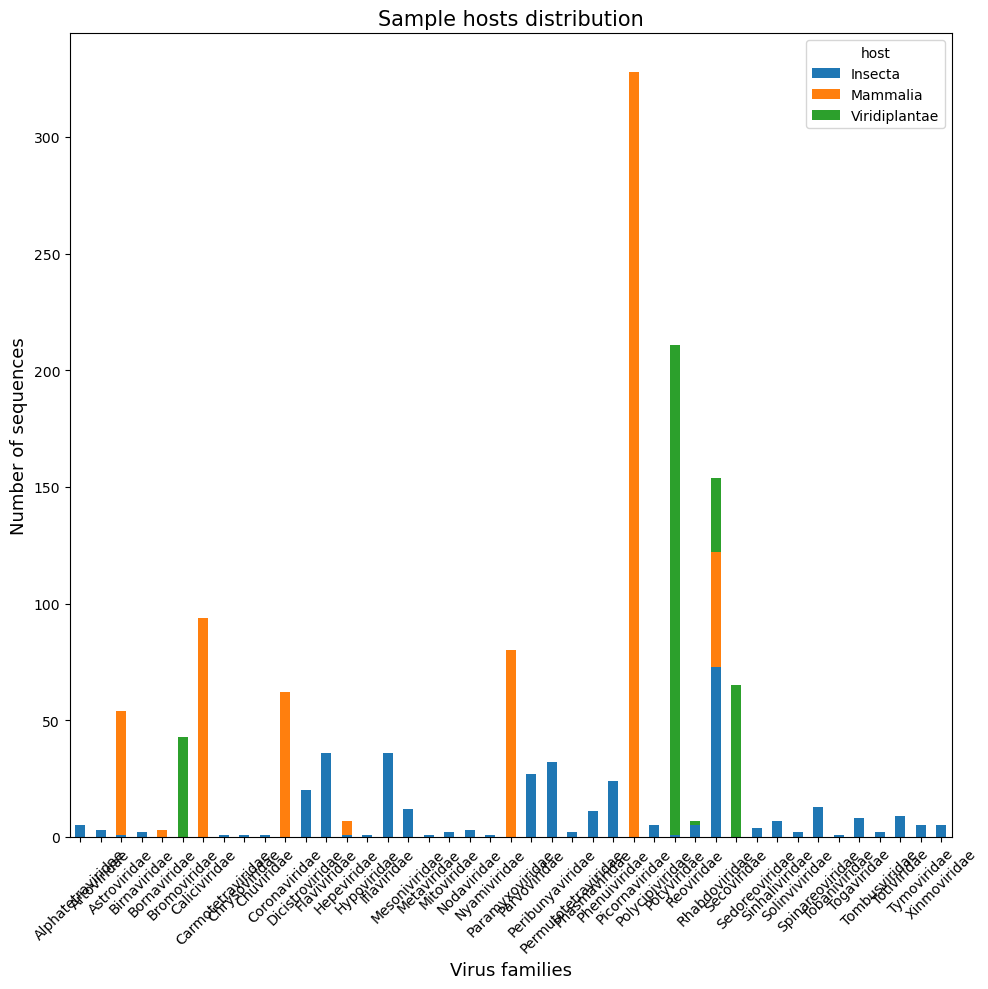

In [146]:
meta_df.groupby(['virus family', 'host']).size().unstack().plot(kind='bar', figsize=(10,10), stacked=True)
plt.xticks(rotation=45, ha='center')
plt.ylabel('Number of sequences', fontsize=13)
plt.xlabel('Virus families', fontsize=13)
plt.title('Sample hosts distribution', fontsize=15)
plt.tight_layout()
#plt.savefig('/home/parazit/ml_virus_host/hosts_distribution.png')
plt.show()